In [2]:
import numpy as np
import matplotlib.pyplot as plt

from mne import Epochs, pick_types, find_events
from mne.channels import read_layout
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
import mne
import numpy as np

print(__doc__)


Automatically created module for IPython interactive environment


In [29]:

# #############################################################################
# # Set parameters and read data

# avoid classification of evoked responses by using epochs that start 1s after
# cue onset.
tmin, tmax = -1., 4.
event_id = dict(hands=2, feet=3)
subject = 1
runs = [6, 10, 14]  # motor imagery: hands vs feet

raw_fnames = eegbci.load_data(subject, runs)
raw_files = [read_raw_edf(f, preload=True) for f in raw_fnames]
raw = concatenate_raws(raw_files)

# strip channel names of "." characters
raw.rename_channels(lambda x: x.strip('.'))

# Apply band-pass filter
raw.filter(7., 30., method='iir')

event_data = mne.events_from_annotations(raw)
event_marker, _ = event_data

picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                   exclude='bads')

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier
epochs = Epochs(raw, event_marker, event_id, tmin, tmax, proj=True, picks=picks,
                baseline=None, preload=True)
epochs_train = epochs.copy()
epochs_train = epochs_train.crop(tmin=1., tmax=2.)
labels = epochs.events[:, -1] - 2

Extracting EDF parameters from /media/mangaldeep/HDD3/DataSets/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /media/mangaldeep/HDD3/DataSets/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /media/mangaldeep/HDD3/DataSets/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) n

In [ ]:
event_marker

In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import ShuffleSplit

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

In [30]:
# Assemble a classifier
svc = LDA()
csp = CSP(n_components=4, reg=None, log=True)

In [14]:
csp

CSP(component_order='mutual_info', cov_est='concat', cov_method_params=None,
  log=True, n_components=4, norm_trace=False, rank=None, reg=None,
  transform_into='average_power')

In [33]:

# Define a monte-carlo cross-validation generator (reduce variance):
cv = ShuffleSplit(len(labels), test_size=0.2, random_state=42)
scores = []
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()

In [34]:

# Use scikit-learn Pipeline with cross_val_score function

clf = Pipeline([('CSP', csp), ('SVC', svc)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)

Computing rank from data with rank=None
    Using tolerance 8.9e-05 (2.2e-16 eps * 64 dim * 6.3e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.4e-05 (2.2e-16 eps * 64 dim * 6.6e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.8e-05 (2.2e-16 eps * 64 dim * 6.2e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.2e-05 (2.2e-16 eps * 64 dim * 6.5e+09  max singular value)


In [35]:
labels

array([1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       1])

In [36]:

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))


Classification accuracy: 0.940741 / Chance level: 0.533333


In [37]:

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)

evoked = epochs.average()
evoked.data = csp.patterns_.T
evoked.times = np.arange(evoked.data.shape[0])


Computing rank from data with rank=None
    Using tolerance 0.00022 (2.2e-16 eps * 64 dim * 1.6e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00024 (2.2e-16 eps * 64 dim * 1.7e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.


In [45]:
csp.get_params()

{'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 4,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'}

In [57]:

layout = read_layout('EEG1020')
evoked.plot_topomap(times=[0, 1, 2, 3, 4, 5], ch_type='eeg',
                    time_format='%i', layout)

SyntaxError: positional argument follows keyword argument (958349536.py, line 3)

Computing rank from data with rank=None
    Using tolerance 8.9e-05 (2.2e-16 eps * 64 dim * 6.3e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.4e-05 (2.2e-16 eps * 64 dim * 6.6e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.8e-05 (2.2e-16 eps * 64 dim * 6.2e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.2e-05 (2.2e-16 eps * 64 dim * 6.5e+09  max singular value)


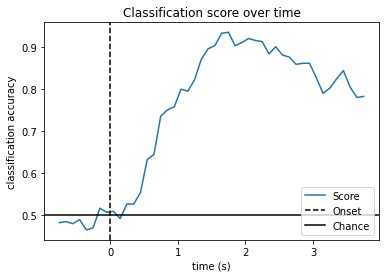

In [51]:
sfreq = raw.info['sfreq']
w_length = int(sfreq * 0.5)   # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows = []

for train_idx, test_idx in cv._iter_indices(epochs_data_train):
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx])

    # fit classifier
    svc.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n:(n + w_length)])
        score_this_window.append(svc.score(X_test, y_test))
    scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label='Score')
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score over time')
plt.legend(loc='lower right')
plt.show()

In [54]:
train_idx

array([31, 37, 18, 29, 41, 16, 14, 23, 20, 24, 26, 42,  7, 19, 40, 39,  8,
       38, 28, 33, 15, 13, 21,  2,  9, 10, 30, 22, 35, 11,  0,  4, 36, 34,
        1, 27])

In [53]:
epochs_data[test_idx][:, :, n:(n + w_length)]

(9, 64, 801)